In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

import opt_utils #参见数据包或者在本文底部copy
import testCase  #参见数据包或者在本文底部copy

#%matplotlib inline #如果你用的是Jupyter Notebook请取消注释
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [64]:
def update_parameters_with_gd(parameters,grads,learning_rate):
    """
    使用梯度下降更新参数
    
    参数：
        parameters - 字典，包含了要更新的参数：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 字典，包含了每一个梯度值用以更新参数
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        learning_rate - 学习率
        
    返回值：
         parameters - 字典，包含了更新后的参数
    """
    L = len(parameters) // 2
    #更新每个参数
    for l in range(L):
        parameters["W" + str(l +1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l +1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    
    return parameters

#测试update_parameters_with_gd
# print("-------------测试update_parameters_with_gd-------------")
# parameters , grads , learning_rate = testCase.update_parameters_with_gd_test_case()
# parameters = update_parameters_with_gd(parameters,grads,learning_rate)
# print("W1 = " + str(parameters["W1"]))
# print("b1 = " + str(parameters["b1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b2 = " + str(parameters["b2"]))


#===================================================mini batch=================================================================================


def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    从（X，Y）中创建一个随机的mini-batch列表
    
    参数：
        X - 输入数据，维度为(输入节点数量，样本的数量)
        Y - 对应的是X的标签，【1 | 0】（蓝|红），维度为(1,样本的数量)
        mini_batch_size - 每个mini-batch的样本数量
        
    返回：
        mini-bacthes - 一个同步列表，维度为（mini_batch_X,mini_batch_Y）
        
    """
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    #1st step: 打乱X, Y 的顺序
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation].reshape((1,m))
    
    #2nd step: 分割X, Y
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    #如果训练集的大小刚好是mini_batch_size的整数倍，那么这里已经处理完了
    #如果训练集的大小不是mini_batch_size的整数倍，那么最后肯定会剩下一些，我们要把它处理了
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

#测试random_mini_batches
# print("-------------测试random_mini_batches-------------")
# X_assess,Y_assess,mini_batch_size = testCase.random_mini_batches_test_case()
# mini_batches = random_mini_batches(X_assess,Y_assess,mini_batch_size)

# print("第1个mini_batch_X 的维度为：",mini_batches[0][0].shape)
# print("第1个mini_batch_Y 的维度为：",mini_batches[0][1].shape)
# print("第2个mini_batch_X 的维度为：",mini_batches[1][0].shape)
# print("第2个mini_batch_Y 的维度为：",mini_batches[1][1].shape)
# print("第3个mini_batch_X 的维度为：",mini_batches[2][0].shape)
# print("第3个mini_batch_Y 的维度为：",mini_batches[2][1].shape)

In [65]:
def initialize_velocity(parameters):
    """
    初始化速度，velocity是一个字典：
        - keys: "dW1", "db1", ..., "dWL", "dbL" 
        - values:与相应的梯度/参数维度相同的值为零的矩阵。
    参数：
        parameters - 一个字典，包含了以下参数：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
    返回:
        v - 一个字典变量，包含了以下参数：
            v["dW" + str(l)] = dWl的速度
            v["db" + str(l)] = dbl的速度
    
    """
    L = len(parameters) // 2 #神经网络的层数
    v = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v
#测试initialize_velocity
# print("-------------测试initialize_velocity-------------")
# parameters = testCase.initialize_velocity_test_case()
# v = initialize_velocity(parameters)

# print('v["dW1"] = ' + str(v["dW1"]))
# print('v["db1"] = ' + str(v["db1"]))
# print('v["dW2"] = ' + str(v["dW2"]))
# print('v["db2"] = ' + str(v["db2"]))


#=============================================================Momentunm========================================================================


def update_parameters_with_momentun(parameters,grads,v,beta,learning_rate):
    """
    使用动量更新参数
    参数：
        parameters - 一个字典类型的变量，包含了以下字段：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
        grads - 一个包含梯度值的字典变量，具有以下字段：
            grads["dW" + str(l)] = dWl
            grads["db" + str(l)] = dbl
        v - 包含当前速度的字典变量，具有以下字段：
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
        beta - 超参数，动量，实数
        learning_rate - 学习率，实数
    返回：
        parameters - 更新后的参数字典
        v - 包含了更新后的速度变量
    """
    L = len(parameters) // 2 
    for l in range(L):
        #计算速度
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]
        
        #更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
    
    return parameters,v

#测试update_parameters_with_momentun
# print("-------------测试update_parameters_with_momentun-------------")
# parameters,grads,v = testCase.update_parameters_with_momentum_test_case()
# update_parameters_with_momentun(parameters,grads,v,beta=0.9,learning_rate=0.01)

# print("W1 = " + str(parameters["W1"]))
# print("b1 = " + str(parameters["b1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b2 = " + str(parameters["b2"]))
# print('v["dW1"] = ' + str(v["dW1"]))
# print('v["db1"] = ' + str(v["db1"]))
# print('v["dW2"] = ' + str(v["dW2"]))
# print('v["db2"] = ' + str(v["db2"]))

In [66]:
def initialize_adam(parameters):
    """
    初始化v和s，它们都是字典类型的变量，都包含了以下字段：
        - keys: "dW1", "db1", ..., "dWL", "dbL" 
        - values：与对应的梯度/参数相同维度的值为零的numpy矩阵
    
    参数：
        parameters - 包含了以下参数的字典变量：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
    返回：
        v - 包含梯度的指数加权平均值，字段如下：
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
        s - 包含平方梯度的指数加权平均值，字段如下：
            s["dW" + str(l)] = ...
            s["db" + str(l)] = ...
    
    """
    L = len(parameters) // 2
    #别忘了初始化！
    v = {}
    s = {}
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
    return (v,s)

#测试initialize_adam
# print("-------------测试initialize_adam-------------")
# parameters = testCase.initialize_adam_test_case()
# v,s = initialize_adam(parameters)

# print('v["dW1"] = ' + str(v["dW1"])) 
# print('v["db1"] = ' + str(v["db1"])) 
# print('v["dW2"] = ' + str(v["dW2"])) 
# print('v["db2"] = ' + str(v["db2"])) 
# print('s["dW1"] = ' + str(s["dW1"])) 
# print('s["db1"] = ' + str(s["db1"])) 
# print('s["dW2"] = ' + str(s["dW2"])) 
# print('s["db2"] = ' + str(s["db2"])) 

def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    """
    使用Adam更新参数
    
    参数：
        parameters - 包含了以下字段的字典：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 包含了梯度值的字典，有以下key值：
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        v - Adam的变量，第一个梯度的移动平均值，是一个字典类型的变量
        s - Adam的变量，平方梯度的移动平均值，是一个字典类型的变量
        t - 当前迭代的次数
        learning_rate - 学习率
        beta1 - 动量，超参数,用于第一阶段，使得曲线的Y值不从0开始（参见天气数据的那个图）
        beta2 - RMSprop的一个参数，超参数
        epsilon - 防止除零操作（分母为0）
    
    返回：
        parameters - 更新后的参数
        v - 第一个梯度的移动平均值，是一个字典类型的变量
        s - 平方梯度的移动平均值，是一个字典类型的变量
    """
    L = len(parameters) // 2
    v_corrected = {} #修正后的值
    s_corrected = {}
    
    for l in range(L):
        #梯度的移动平均值,输入："v , grads , beta1",输出：" v "
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        
        #计算第一阶段的偏差修正后的估计值，输入"v , beta1 , t" , 输出："v_corrected"
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1,t))
        
        #计算平方梯度的移动平均值，输入："s, grads , beta2"，输出："s"
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads["dW" + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads["db" + str(l + 1)])
        
        #计算第二阶段的偏差修正后的估计值，输入："s , beta2 , t"，输出："s_corrected"
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2,t))
        
        #更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * (v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * (v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon))
        
    return (parameters,v,s)

#测试update_with_parameters_with_adam
# print("-------------测试update_with_parameters_with_adam-------------")
# parameters , grads , v , s = testCase.update_parameters_with_adam_test_case()
# update_parameters_with_adam(parameters,grads,v,s,t=2)

# print("W1 = " + str(parameters["W1"]))
# print("b1 = " + str(parameters["b1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b2 = " + str(parameters["b2"]))
# print('v["dW1"] = ' + str(v["dW1"])) 
# print('v["db1"] = ' + str(v["db1"])) 
# print('v["dW2"] = ' + str(v["dW2"])) 
# print('v["db2"] = ' + str(v["db2"])) 
# print('s["dW1"] = ' + str(s["dW1"])) 
# print('s["db1"] = ' + str(s["db1"])) 
# print('s["dW2"] = ' + str(s["dW2"])) 
# print('s["db2"] = ' + str(s["db2"])) 

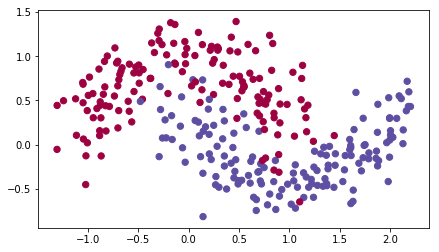

In [67]:
train_X, train_Y = opt_utils.load_dataset(is_plot=True)

In [83]:
def model(X,Y,layers_dims,optimizer,learning_rate=0.0007,
          mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,
          epsilon=1e-8,num_epochs=10000,print_cost=True,is_plot=True):
    
    """
    可以运行在不同优化器模式下的3层神经网络模型。
    
    参数：
        X - 输入数据，维度为（2，输入的数据集里面样本数量）
        Y - 与X对应的标签
        layers_dims - 包含层数和节点数量的列表
        optimizer - 字符串类型的参数，用于选择优化类型，【 "gd" | "momentum" | "adam" 】
        learning_rate - 学习率
        mini_batch_size - 每个小批量数据集的大小
        beta - 用于动量优化的一个超参数
        beta1 - 用于计算梯度后的指数衰减的估计的超参数
        beta2 - 用于计算平方梯度后的指数衰减的估计的超参数
        epsilon - 用于在Adam中避免除零操作的超参数，一般不更改
        num_epochs - 整个训练集的遍历次数，（视频2.9学习率衰减，1分55秒处，视频中称作“代”）,相当于之前的num_iteration
        print_cost - 是否打印误差值，每遍历1000次数据集打印一次，但是每100次记录一个误差值，又称每1000代打印一次
        is_plot - 是否绘制出曲线图
        
    返回：
        parameters - 包含了学习后的参数
        
    """
    L = len(layers_dims)
    costs = []
    t = 0 #每学习完一个mini batch就+1
    seed = 10 #随机种子
    
    #初始化参数
    parameters = opt_utils.initialize_parameters(layers_dims)
    
    #选择优化器
    if optimizer == "gd":
        pass #不使用任何优化器，直接使用梯度下降法
    elif optimizer == "momentum":
        v = initialize_velocity(parameters) #使用动量
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)#使用Adam优化
    else:
        print("optimizer参数错误，程序退出。")
        exit(1)
    
    #开始学习
    for i in range(num_epochs):
        #定义随机 minibatches,我们在每次遍历数据集之后增加种子以重新排列数据集，使每次数据的顺序都不同
        seed = seed + 1
        minibatches = random_mini_batches(X,Y,mini_batch_size,seed)
        
        for minibatch in minibatches:
            #选择一个minibatch
            (minibatch_X,minibatch_Y) = minibatch
            
            #前向传播
            A3 , cache = opt_utils.forward_propagation(minibatch_X,parameters)
            
            #计算误差
            cost = opt_utils.compute_cost(A3 , minibatch_Y)
            
            #反向传播
            grads = opt_utils.backward_propagation(minibatch_X,minibatch_Y,cache)
            
            #更新参数~~~~~~~~~~~~~~~~~~~~~~~~
            if optimizer == 'gd':
                parameters = update_parameters_with_gd(parameters,grads,learning_rate)
            elif optimizer == 'momentum':
                parameters = update_parameters_with_momentun(parameters, grads, v, beta, learning_rate)
            elif optimizer == 'adam':
                t = t + 1 
                parameters, v, s = update_parameters_with_adam(parameters, grads,v, s, t, learning_rate, beta1, beta2, epsilon) #返回3个值！！！
                
        #记录误差值
        if i % 100 == 0:
            costs.append(cost)
            #是否打印误差
            if print_cost and i % 1000 == 0:
                print("第" + str(i) + "次便利整个数据集, 当前误差值：" + str(cost))
    
    #便利一次数据集结束
    
    
    #是否绘制
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (per 100)')
        plt.title("learning rate = " + str(learning_rate))
        plt.show()
    
    return parameters

第0次便利整个数据集, 当前误差值：0.690735512291113
第1000次便利整个数据集, 当前误差值：0.6852725328458241
第2000次便利整个数据集, 当前误差值：0.6470722240719003
第3000次便利整个数据集, 当前误差值：0.6195245549970403
第4000次便利整个数据集, 当前误差值：0.5765844355950944
第5000次便利整个数据集, 当前误差值：0.6072426395968576
第6000次便利整个数据集, 当前误差值：0.5294033317684576
第7000次便利整个数据集, 当前误差值：0.46076823985930115
第8000次便利整个数据集, 当前误差值：0.465586082399045
第9000次便利整个数据集, 当前误差值：0.46451797221676844


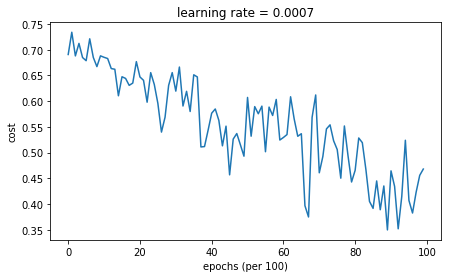

Accuracy: 0.7966666666666666


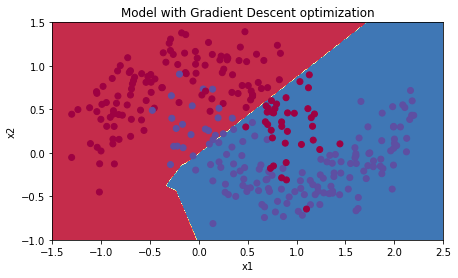

In [88]:
#使用普通的梯度下降
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd",is_plot=True)

#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, np.squeeze(train_Y))

第0次便利整个数据集, 当前误差值：0.6907412988351506
第1000次便利整个数据集, 当前误差值：0.6853405261267578
第2000次便利整个数据集, 当前误差值：0.6471448370095255
第3000次便利整个数据集, 当前误差值：0.6195943032076022
第4000次便利整个数据集, 当前误差值：0.5766650344073023
第5000次便利整个数据集, 当前误差值：0.607323821900647
第6000次便利整个数据集, 当前误差值：0.5294761758786996
第7000次便利整个数据集, 当前误差值：0.46093619004872366
第8000次便利整个数据集, 当前误差值：0.465780093701272
第9000次便利整个数据集, 当前误差值：0.4647395967922748


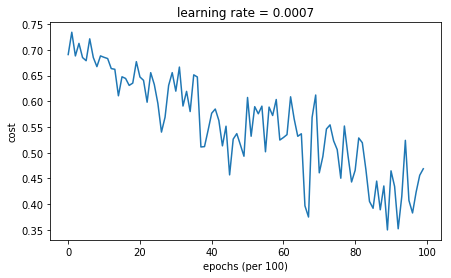

Accuracy: 0.7966666666666666


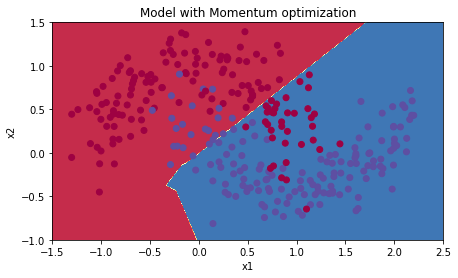

In [87]:
#使用动量的梯度下降
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9,optimizer="momentum",is_plot=True)

#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, np.squeeze(train_Y))

第0次便利整个数据集, 当前误差值：0.6905522446113365
第1000次便利整个数据集, 当前误差值：0.18550136438550574
第2000次便利整个数据集, 当前误差值：0.150830465752532
第3000次便利整个数据集, 当前误差值：0.07445438570997183
第4000次便利整个数据集, 当前误差值：0.12595915651337164
第5000次便利整个数据集, 当前误差值：0.10434443534245487
第6000次便利整个数据集, 当前误差值：0.10067637504120643
第7000次便利整个数据集, 当前误差值：0.0316520301351156
第8000次便利整个数据集, 当前误差值：0.11197273131244204
第9000次便利整个数据集, 当前误差值：0.19794007152465481


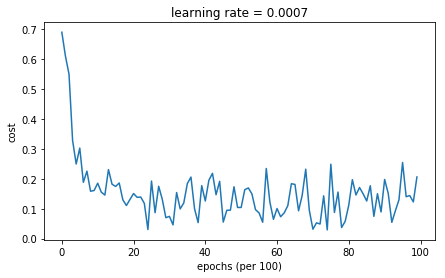

Accuracy: 0.94


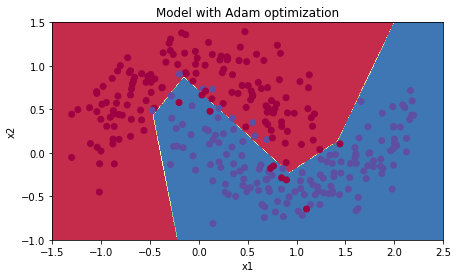

In [91]:
#使用Adam优化的梯度下降
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="adam",is_plot=True)
#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, np.squeeze(train_Y))